In [1]:
import os
import glob
import pickle
import gzip
import numpy as np
import pandas as pd

import tensorflow as tf
#tf.enable_eager_execution()

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
from matplotlib import pyplot as plt
%matplotlib inline
from werdich_cfr.tfutils.TFRprovider import DatasetProvider
from werdich_cfr.tfutils.Modeltrainer import VideoTrainer
from werdich_cfr.utils.visuals import ImageSliceViewer3D

TensorFlow Version: 2.1.0


### Recover data from TFRecords: look at the postprocessed images ###

In [2]:
# Directories and files
cfr_data_root = os.path.normpath('/mnt/obi0/andreas/data/cfr')
meta_date = '200208'
tfr_dir = os.path.join(cfr_data_root, 'tfr_'+meta_date, 'resized')
meta_dir = os.path.join(cfr_data_root, 'metadata_'+meta_date)

# TFR file
tfr_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_1.tfrecords')
parquet_file = os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_1.parquet')

# Load df 
df = pd.read_parquet(parquet_file)
df.head(50)

,mrn,study,echo_study_date,reportID,days_post_cfr,subjectid,report_number,cfr_study_date,cfr_report_date,cfr,filename,dir,datetime,fileid,institution,model,manufacturer,frame_time,number_of_frames,heart_rate,deltaX,deltaY,a2c,a2c_laocc,a2c_lvocc_s,a3c,a3c_laocc,a3c_lvocc_s,a4c,a4c_far,a4c_laocc,a4c_lvocc_s,a4c_rv,a4c_rv_laocc,a5c,apex,other,plax_far,plax_lac,plax_laz,plax_laz_ao,plax_plax,psax_avz,psax_az,psax_mv,psax_pap,rvinf,subcostal,suprasternal,max_view,mode,rate,im_array_shape
48253,26588848,4905336e6fcdf6f3_4903a58793b3fabb933e8233553c,2012-04-04,122050,-306,5350,EVS0355444,2013-02-04,2012-04-04,1.580292,4905336e6fcdf6f3_4903a58793b3fabb933e8233553c_...,/mnt/obi0/phi/echo/npyFiles/BWH/4905/4905336e6...,2012-04-04 13:51:40,4905336e6fcdf6f3_4903a58793b3fabb933e8233553c_...,BWH,iE33,Philips Medical Systems,35.024000,86.0,73.0,0.056903,0.056903,7.194284e-09,1.747568e-06,2.835884e-09,2.096237e-09,7.237569e-09,1.980606e-08,0.999232,5.698615e-05,1.437268e-09,4.514912e-10,1.400618e-05,5.706585e-08,1.692767e-05,8.631115e-09,1.386226e-16,1.035368e-09,4.143198e-09,5.000943e-08,6.606570e-09,2.315859e-08,1.867279e-09,1.690427e-06,2.795820e-12,5.961863e-04,8.051256e-05,1.562224e-10,2.104095e-07,a4c,train,28.6,"[341, 455, 40]"
65118,20689774,4903a2b8e4fc0f49_4903a44517b58fa65e5405918608,2006-12-22,87329,308,3538,0625480D,2006-02-17,2006-12-07,1.313668,4903a2b8e4fc0f49_4903a44517b58fa65e5405918608_...,/mnt/obi0/phi/echo/npyFiles/BWH/4903/4903a2b8e...,2006-12-22 08:00:14,4903a2b8e4fc0f49_4903a44517b58fa65e5405918608_...,BWH,Vivid i,GEMS Ultrasound,43.538954,52.0,86.0,0.051151,0.051151,4.376870e-04,3.339637e-06,3.295374e-07,7.809979e-05,2.765472e-06,2.325215e-07,0.720921,1.147139e-08,1.307347e-09,7.238339e-07,1.220957e-01,6.534848e-07,4.589416e-07,1.222173e-06,9.731261e-09,3.142928e-10,3.228629e-07,2.708157e-08,3.039488e-07,3.810025e-04,1.297817e-03,7.564623e-04,1.832382e-08,1.539375e-01,4.420263e-05,2.419375e-09,3.992833e-05,a4c,train,23.0,"[222, 325, 40]"
103503,16291148,4a1046249cf2147e_4903a581a72ca3ed85a2e06c5514,2014-07-21,132791,18,5917,EVS0498935,2014-07-03,2014-07-21,2.392808,4a1046249cf2147e_4903a581a72ca3ed85a2e06c5514_...,/mnt/obi0/phi/echo/npyFiles/BWH/4a10/4a1046249...,2014-07-21 09:58:38,4a1046249cf2147e_4903a581a72ca3ed85a2e06c5514_...,BWH,iE33,Philips Medical Systems,36.288000,105.0,62.0,0.038480,0.038480,3.360166e-07,2.017488e-03,6.069954e-06,8.803371e-07,4.636676e-05,1.243658e-06,0.990584,2.048770e-05,1.754488e-06,1.292219e-06,4.341480e-03,3.467489e-08,6.698047e-06,2.064429e-07,5.663601e-08,4.339724e-05,2.856501e-06,1.675225e-05,6.213040e-08,2.554903e-03,3.763626e-06,9.868217e-05,3.959241e-08,1.460684e-04,1.051362e-04,5.664334e-12,5.535317e-08,a4c,train,27.6,"[231, 308, 40]"
64025,25191578,4906a0bc901f322b_4903a585855f54514ebb59ecfc58,2010-11-27,106162,44,4340,EVS0270825,2010-10-14,2010-10-20,1.196791,4906a0bc901f322b_4903a585855f54514ebb59ecfc58_...,/mnt/obi0/phi/echo/npyFiles/BWH/4906/4906a0bc9...,2010-11-27 11:33:38,4906a0bc901f322b_4903a585855f54514ebb59ecfc58_...,BWH,iE33,Philips Medical Systems,33.333000,59.0,100.0,0.041792,0.041792,7.900749e-11,6.368030e-14,7.073855e-15,2.925860e-13,5.757498e-16,1.918438e-13,1.000000,2.378554e-12,6.053567e-15,4.354250e-13,2.197853e-12,4.189612e-14,1.549342e-11,7.424398e-16,1.924909e-11,5.019234e-15,1.456539e-13,1.744902e-10,2.398398e-16,2.528707e-14,3.139895e-12,1.305985e-12,1.940245e-13,1.225240e-11,7.914446e-18,8.069094e-19,4.959512e-14,a4c,train,30.0,"[251, 334, 40]"
96696,23576143,49004bea0c978be3_4903a581a72e1f7abbb2a3733645,2014-05-31,132861,-38,5923,EVS0489610,2014-07-08,2014-05-31,1.503937,49004bea0c978be3_4903a581a72e1f7abbb2a3733645_...,/mnt/obi0/phi/echo/npyFiles/BWH/4900/49004bea0...,2014-05-31 13:33:46,49004bea0c978be3_4903a581a72e1f7abbb2a3733645_...,BWH,Vivid S6,GE Healthcare,33.640642,78.0,76.0,0.043165,0.043165,6.646330e-05,6.403693e-06,9.228484e-09,4.600138e-08,1.704858e-10,2.491048e-09,0.998757,1.121901e-07,8.564120e-10,2.499403e-07,2.006507e-08,5.375426e-09,

In [17]:
provider = DatasetProvider(tfr_file_list = [tfr_file],
                           repeat_count = 1,
                           n_frames = 40,
                           cfr_boundaries = [1.248, 1.591, 2.08],
                           output_height=299,
                           output_width=299,
                           im_scale_factor=0.5642,
                           record_output=False)                     

In [45]:
def process_image(image, shape):

    # original shape is [height, width, frames] transform to [frames, height, width, 1]
    # If there is no scale-factor, the images will be resized to fit
    image = tf.reshape(image, shape=shape)
    image = tf.transpose(image, perm = [2, 0, 1])
    image = tf.expand_dims(image, axis = -1)
    
    # Re-size the image with the scale factor to fit them all
    im_size = tf.cast(tf.slice(shape, [0], [2]), dtype = tf.float32)
    new_im_size = tf.cast(tf.math.ceil(tf.math.scalar_mul(0.5, im_size)), tf.int32)
    image = tf.image.resize(image, size=new_im_size, antialias=True)
    
    # Crop or pad to the desired output size
    image = tf.image.resize_with_crop_or_pad(image, 299, 299)
    
    # Scale image to have mean 0 and variance 1
    # image = tf.cast(image, tf.float64)
    image = tf.image.adjust_contrast(image, contrast_factor=2)
    output_image = tf.image.per_image_standardization(image)

    return output_image

In [5]:
def parse(serialized):

    example = {'image': tf.io.FixedLenFeature([], tf.string),
               'shape': tf.io.FixedLenFeature([], tf.string),
               'cfr': tf.io.FixedLenFeature([], tf.float32),
               'record': tf.io.FixedLenFeature([], tf.int64)}

    # Extract example from the data record
    example = tf.io.parse_single_example(serialized, example)

    # Convert image to tensor and shape it
    image_raw = tf.io.decode_raw(example['image'], tf.uint16)
    shape = tf.io.decode_raw(example['shape'], tf.uint16)
    shape = tf.cast(shape, tf.int32) # tf.reshape requires int16 or int32 types
    image = tf.reshape(image_raw, shape)
    
    # Here, we have recovered the original shape of the images.
    # Now we need to process them.

    cfr = example['cfr']
    record = example['record']
    
    output = process_image(image, shape)
    
    # For training, use only model input/outputs
    return output

In [46]:
dataset = tf.data.TFRecordDataset([tfr_file])
dataset = dataset.map(map_func = parse, num_parallel_calls = 1)
for out in dataset.take(1):
    output = out

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [15]:
p_list = [1.248, 1.591, 2.08]
# Model parameters
model_dict_1 = {'name': 'test',
              'im_size': (299, 299, 1),
              'im_scale_factor': 0.5642,
              'n_frames': 40,
              'cfr_boundaries': [1.248, 1.591, 2.08],
              'cl_outputs': len(p_list)+1,
              'filters': 32,
              'pool_nodes': 256,
              'fc_nodes': 256,
              'fullnet': True}

model_dict_2 = {'name': 'test',
              'im_size': (299, 299, 1),
              'im_scale_factor': None,
              'n_frames': 40,
              'cfr_boundaries': [1.248, 1.591, 2.08],
              'cl_outputs': len(p_list)+1,
              'filters': 32,
              'pool_nodes': 256,
              'fc_nodes': 256,
              'fullnet': True}

vtrain = VideoTrainer(log_dir = None, model_dict = model_dict_2, train_dict = None)
n_steps, dset = vtrain.build_dataset(tfr_files = [tfr_file],
                                        batch_size = 10,
                                        buffer_n_batches = None,
                                        repeat_count = 1,
                                        shuffle = False)

### Percentile thresholds for classification ###

In [13]:
# TFR .parquet data files
train_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_train_200208_*.parquet'))
eval_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_eval_200208_*.parquet'))
test_files = glob.glob(os.path.join(tfr_dir, 'cfr_resized_a4c_test_200208_*.parquet'))

train_df = pd.concat([pd.read_parquet(file) for file in train_files])
eval_df = pd.concat([pd.read_parquet(file) for file in eval_files])
test_df = pd.concat([pd.read_parquet(file) for file in test_files])
dset = pd.concat([train_df, eval_df, test_df], axis = 0, ignore_index=True).reset_index(drop=True)
print(dset.shape)

(5064, 53)


In [5]:
print('Size of cfr table:', dset.shape)
cfr_array = dset.cfr.values
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
print('Percentile boundaries:', p_list)

Size of cfr table: (5064, 53)
Percentile boundaries: [1.259, 1.591, 2.066]


In [10]:
p_list = [np.round(np.percentile(cfr_array, p), decimals = 3) for p in (25, 50, 75)]
percentile_list = sorted(p_list)
print('Percentile boundaries:', p_list)

Percentile boundaries: [1.259, 1.591, 2.066]


In [11]:
def cfr_label(cfr_value):
    if cfr_value < percentile_list[0]:
        label = 0
    elif cfr_value >= percentile_list[-1]:
        label = len(percentile_list)
    
    for p in range(1, len(percentile_list)):
        
        if (cfr_value >= percentile_list[p-1]) & (cfr_value < percentile_list[p]):
            label = p
    
    return label

df['label'] = df['cfr'].apply(cfr_label)
print(df.label.iloc[0:10].values)

[1 1 3 0 1 3 1 2 3 0]


In [12]:
percentile_list = p_list
def cfr_p_label(cfr_value):
    return np.digitize(cfr_value, bins = percentile_list)
# Setting the threshold, check the number of positives and negatives
df['labelp'] = df['cfr'].apply(cfr_p_label)
print(df.labelp.iloc[0:10].values)

[1 1 3 0 1 3 1 2 3 0]


In [7]:
label_list = sorted(df.label.unique())
print('Unique labels:', label_list)
df.head(20)
# Number of samples in each group
samples = [df[df.label == l].shape[0] for l in label_list]
for l in label_list:
    print('Label:', l, 'samples:', samples[l])

Unique labels: [0, 1, 2, 3]
Label: 0 samples: 304
Label: 1 samples: 238
Label: 2 samples: 254
Label: 3 samples: 248


In [8]:
tfr_file

'/mnt/obi0/andreas/data/cfr/tfr_200208/resized/cfr_resized_a4c_test_200208_0.tfrecords'

In [16]:
for out in dset.take(1):
    output_batch = out
    

# Output batch is a list of dictionaries [INPUT, OUTPUT]:
print('Input keys: ', output_batch[0].keys())
print('Output keys:', output_batch[1].keys())

Input keys:  dict_keys(['video'])
Output keys: dict_keys(['class_output', 'score_output'])


In [17]:
image_batch = output_batch[0]['video'].numpy()
print('Video batch shape:', image_batch.shape)
class_label_batch = output_batch[1]['class_output'].numpy()
print('Class batch output shape:', class_label_batch.shape)
cfr_batch = output_batch[1]['score_output'].numpy()
print('CFR batch output shape:', cfr_batch.shape)

Video batch shape: (10, 40, 299, 299, 1)
Class batch output shape: (10, 4)
CFR batch output shape: (10,)


In [10]:
output_batch[0]['video'].shape

TensorShape([10, 40, 299, 299, 1])

In [17]:
# Pick a random sample from the batch
#sample_idx = np.random.randint(batch_size, size = 1)[0]
sample_idx = 1

# Image sample
video_sample = image_batch[sample_idx]
class_label_onehot = class_label_batch[sample_idx]
class_label = np.argmax(class_label_onehot)

print('Batch sample:', sample_idx)
print('Video shape:', video_sample.shape)
print('class label:', class_label)

#Pick a few images and check the stats
image_idx_list = np.random.randint(video_sample.shape[0], size = 10)
for frame in image_idx_list:
    im = video_sample[frame]
    print()
    print('frame:', frame)
    print('min:', np.amin(im))
    print('max:', np.amax(im))
    print('mean:', np.mean(im))
    print('std:', np.std(im))
    print('color channels:', im[20, 20, :])

Batch sample: 1
Video shape: (40, 299, 299, 1)
class label: 1

frame: 8
min: -0.22249238
max: 15.94098
mean: -1.2138623e-06
std: 0.99999917
color channels: [-0.22249238]

frame: 26
min: -0.2233687
max: 15.822756
mean: 4.519555e-07
std: 0.99999994
color channels: [-0.2233687]

frame: 24
min: -0.22193934
max: 15.881643
mean: 2.1573706e-07
std: 1.0000014
color channels: [-0.22193934]

frame: 31
min: -0.22554015
max: 15.930114
mean: -1.5429296e-07
std: 0.9999998
color channels: [-0.22554015]

frame: 37
min: -0.21535729
max: 15.933768
mean: 4.4922464e-07
std: 1.0000012
color channels: [-0.21535729]

frame: 20
min: -0.21942344
max: 16.022503
mean: -9.831056e-08
std: 1.0000002
color channels: [-0.21942344]

frame: 34
min: -0.21701296
max: 15.969592
mean: 6.963665e-07
std: 1.0000006
color channels: [-0.21701296]

frame: 1
min: -0.22967814
max: 15.54923
mean: -8.8889135e-07
std: 0.9999993
color channels: [-0.22967814]

frame: 7
min: -0.22005956
max: 16.058441
mean: -1.09233955e-08
std: 1.000001

In [18]:
im_array = output_batch[0]['video'][3]
im_array = np.moveaxis(np.squeeze(im_array), 0, -1)
ImageSliceViewer3D(im_array)


interactive(children=(RadioButtons(description='Slice plane selection:', options=('x-y', 'y-z', 'z-x'), style=…

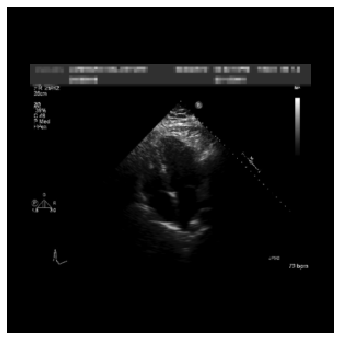

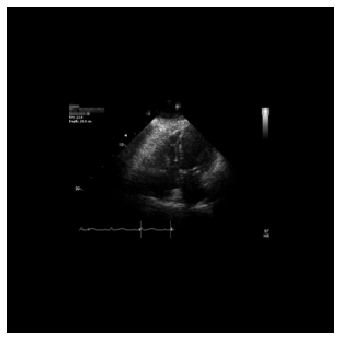

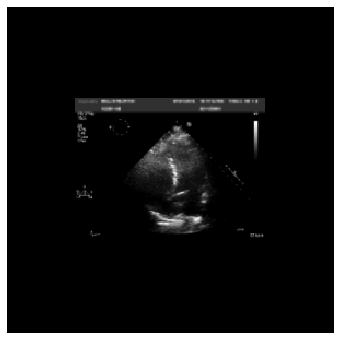

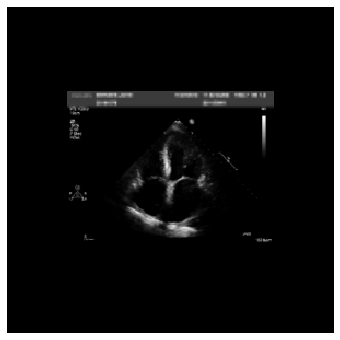

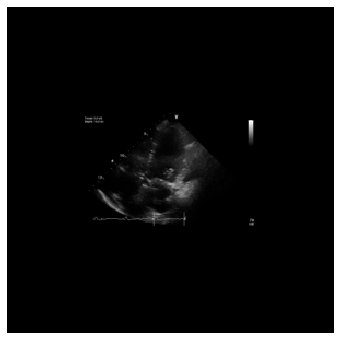

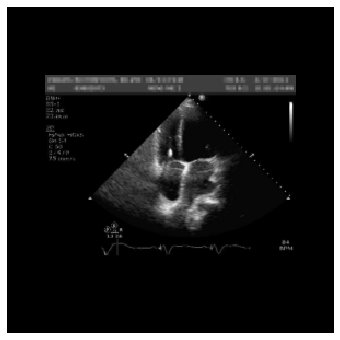

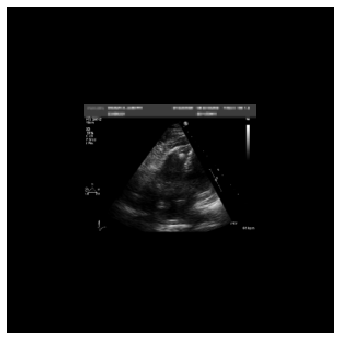

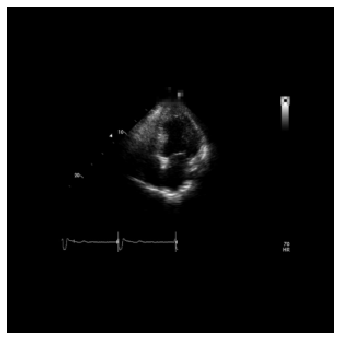

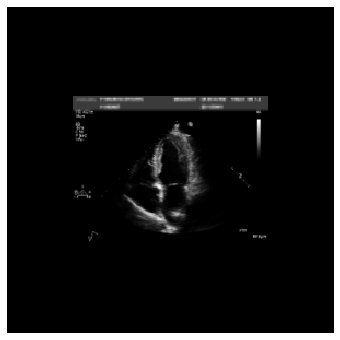

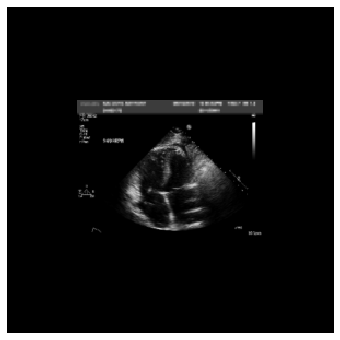

In [19]:
# Let's take a look at one of the videos
# Pick a random sample from the batch
frame = 5
save_dir = os.path.join(cfr_data_root, 'proc_test', 'im_scaled_resize_pad')

for sample in range(len(output_batch[0]['video'])):
    im_array = np.squeeze(output_batch[0]['video'][sample])
    im_array = np.moveaxis(im_array, 0, -1)
    im = im_array[:, :, frame]
    fig, ax = plt.subplots(figsize = (6, 6))
    ax.imshow(im, cmap = 'gray')
    plt.axis('off')
    save_file = os.path.join(save_dir, 'video_'+str(sample)+'.png')
    plt.savefig(save_file, bbox_inches='tight')